In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
# load data
df = pd.read_csv("data/quora/quora_duplicate_questions.tsv", delimiter='\t')
df = df[['question1', 'question2', 'is_duplicate']]

# split data
df_true_duplicate = df[df['is_duplicate'] == 1]
df_false_duplicate = df[df['is_duplicate'] == 0]
# df_false_duplicate = df_false_duplicate[:len(df_true_duplicate)]  # balance dataset

In [4]:
#################
# Preprocessing #
#################

import re
import logging
import nltk
import string

def clean_sent(sentence):
    # nltk tokenizer
    try:
        words = nltk.tokenize.word_tokenize(sentence)
    except:
        return ' '
    txt = ' '.join(l for l in words)
    # remove punctuation (including dashes) and common words
    punct = '!"()*+,./:;<=>?@[\]^_`{|}~'
    for p in punct: txt = txt.replace(p, '')
    # convert to lower case
    txt = txt.lower()
    # refit dashes (single words)
    txt = re.sub(' - ', '-', txt)
    # strip leading and trailing white space
    txt = txt.strip()
    # tokenize (split based on whitespace)
    return txt

# quora corpus
corpus = [clean_sent(q).split() for q in df['question1']]
for q in df['question2']: corpus.append(clean_sent(q).split())

In [5]:
######################
# Corpora Statistics #
######################

from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.metrics.pairwise import euclidean_distances as euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances as manhattan_distances

# get word probability distribution p(w)
corpora = [w for sents in corpus for w in sents]
fd_doc_words = nltk.FreqDist(corpora)
total_freq = len(corpora)
print(fd_doc_words.most_common(100))
print('astrology:', fd_doc_words['astrology'], fd_doc_words['astrology'] / total_freq)
print('how:', fd_doc_words['how'], fd_doc_words['how'] / total_freq)

[('the', 377379), ('what', 324199), ('is', 270864), ('i', 222219), ('how', 220523), ('a', 211122), ('to', 205460), ('in', 196496), ('do', 168951), ('of', 159795), ('are', 146406), ('and', 133235), ('can', 114665), ('for', 104432), ('you', 93054), ('why', 83979), ('it', 70997), ('my', 70912), ('best', 70471), ('on', 60517), ('does', 59297), ('or', 44007), ('be', 43931), ('which', 43903), ('if', 43754), ('some', 41674), ('have', 41304), ('that', 40696), ('with', 39721), ('get', 39513), ('should', 39448), ("'s", 39434), ('an', 36957), ('from', 35224), ('your', 33904), ('india', 29371), ('will', 28180), ('people', 26367), ('when', 26170), ('who', 26052), ('like', 25496), ('at', 25189), ('good', 24761), ('would', 23864), ('there', 23649), ('as', 22642), ("n't", 21412), ('about', 21140), ('not', 20964), ('between', 20286), ('one', 19773), ('did', 19486), ('most', 18918), ('we', 18515), ("''", 18377), ('quora', 18170), ('make', 18164), ('way', 18068), ('where', 17375), ('by', 17250), ('any', 

In [6]:
###################
# Word Embeddings # 
###################

import gensim
import matplotlib.pyplot as plt

# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# my_path = 'C:\\Users\\ASUS\\Documents\\Telecom\\PRIM\\code\\word_embeddings\\'
my_path = "word_embeddings/glove.6B/"

# quora corpus
corpus = [clean_sent(q).split() for q in df['question1']]
for q in df['question2']: corpus.append(clean_sent(q).split())

# initialize W2V model
my_model = gensim.models.word2vec.Word2Vec(size=300, min_count=2, sg=1)
my_model.build_vocab(corpus)

# update with Glove
my_model.intersect_word2vec_format(my_path + "glove.6B.300d_w2vformat.txt", binary=False)

# fine tune on quora corpus
my_model.train(corpus, total_examples=my_model.corpus_count, epochs=my_model.iter)

# trim memory
my_model.init_sims(replace=True)

Using TensorFlow backend.


In [7]:
# Word Mover's Distance
wmd_true = []
for q1, q2 in zip(tqdm(df_true_duplicate['question1']), df_true_duplicate['question2']):
    clean_q1 = clean_sent(q1).split()
    clean_q2 = clean_sent(q2).split()
    if len(clean_q1) > 1 and len(clean_q2) > 1:
        d12 = my_model.wmdistance(clean_q1, clean_q2)
        if d12 < 100:
            wmd_true.append(d12)
        else:
            print(d12)

wmd_false = []
for q1, q2 in zip(tqdm(df_false_duplicate['question1']), df_false_duplicate['question2']):
    clean_q1 = clean_sent(q1).split()
    clean_q2 = clean_sent(q2).split()
    if len(clean_q1) > 1 and len(clean_q2) > 1:
        d12 = my_model.wmdistance(clean_q1, clean_q2)
        if d12 < 100:
            wmd_false.append(d12)
        else:
            print(d12)

  4%|▍         | 10507/255027 [00:18<07:08, 570.44it/s]

inf


 22%|██▏       | 54946/255027 [01:36<06:29, 513.29it/s]

inf


100%|██████████| 255027/255027 [07:30<00:00, 565.60it/s]


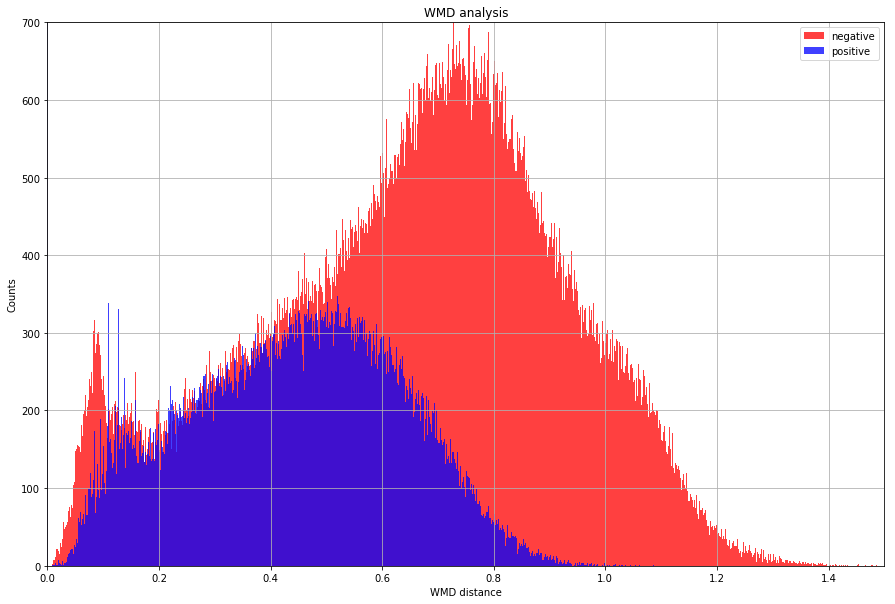

In [11]:
# Histogram
plt.figure(figsize=(15, 10))
n2, bins2, patches2 = plt.hist(wmd_false, 1000, facecolor='r', alpha=0.75)
n1, bins1, patches1 = plt.hist(wmd_true, 1000, facecolor='b', alpha=0.75)
plt.xlabel('WMD distance')
plt.ylabel('Counts')
plt.title('WMD analysis')
plt.axis([0., 1.5, 0, 700])
plt.grid(True)
plt.legend(["negative", "positive"])
plt.show()